In [4]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input, MultiHeadAttention, LayerNormalization
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler
# import json
# import os
# from datetime import datetime, timedelta
# import random
# import matplotlib.pyplot as plt

# # Import data generator if available
# try:
#     from data_generator import generate_network_dataset
# except ImportError:
#     print("Data generator module not found. Will use existing dataset.")

# # Set random seeds for reproducibility
# random.seed(42)
# np.random.seed(42)
# tf.random.set_seed(42)

# class BandwidthAllocationPredictor:
#     def __init__(self, dataset_path=None, df=None):
#         """
#         Initialize with either a dataset path or dataframe
        
#         Parameters:
#         -----------
#         dataset_path : str, optional
#             Path to the CSV dataset
#         df : pandas.DataFrame, optional
#             Existing dataframe with bandwidth data
#         """
#         if df is not None:
#             self.df = df
#         elif dataset_path is not None:
#             if os.path.exists(dataset_path):
#                 self.df = pd.read_csv(dataset_path)
#                 self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
#             else:
#                 print(f"Dataset file {dataset_path} not found, generating synthetic data...")
#                 try:
#                     self.df = generate_network_dataset(
#                         dataset_path, 
#                         start_date=datetime(2023, 1, 1), 
#                         end_date=datetime(2025, 3, 20)
#                     )
#                     self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
#                 except NameError:
#                     raise ValueError(f"Dataset {dataset_path} not found and data_generator module not available.")
#         else:
#             raise ValueError("Either dataset_path or df must be provided")
        
#         # Print column names to diagnose naming issues
#         print("Available columns in dataset:", list(self.df.columns))
        
#         # Create mapping dictionaries for service groups and names
#         self.service_groups = self.df['service_group'].unique()
#         print(f"Service groups in dataset: {list(self.service_groups)}")
        
#         self.group_ids = {}
#         self.service_ids = {}
        
#         for _, row in self.df[['service_group', 'group_id', 'service_name', 'service_id']].drop_duplicates().iterrows():
#             self.group_ids[row['service_group']] = row['group_id']
#             if row['service_name'] not in self.service_ids:
#                 self.service_ids[row['service_name']] = row['service_id']
        
#         # Analysis of bandwidth distribution
#         self.analyze_bandwidth_distribution()
        
#         # Prepare features for prediction
#         self.prepare_features()
    
#     def analyze_bandwidth_distribution(self):
#         """
#         Analyze the distribution of bandwidth values to determine appropriate scaling
#         """
#         bandwidth_col = 'bandwidth_speed'
        
#         # Calculate statistics
#         bandwidth_min = self.df[bandwidth_col].min()
#         bandwidth_max = self.df[bandwidth_col].max()
#         bandwidth_mean = self.df[bandwidth_col].mean()
#         bandwidth_median = self.df[bandwidth_col].median()
#         bandwidth_std = self.df[bandwidth_col].std()
        
#         print("\nBandwidth Distribution Analysis:")
#         print(f"Min: {bandwidth_min:.2f}, Max: {bandwidth_max:.2f}")
#         print(f"Mean: {bandwidth_mean:.2f}, Median: {bandwidth_median:.2f}")
#         print(f"Standard Deviation: {bandwidth_std:.2f}")
        
#         # Store for scaling during prediction
#         self.bandwidth_stats = {
#             'min': bandwidth_min,
#             'max': bandwidth_max,
#             'mean': bandwidth_mean,
#             'median': bandwidth_median,
#             'std': bandwidth_std
#         }
        
#         # Analyze by service group
#         print("\nBandwidth by Service Group:")
#         self.service_group_stats = {}
#         for group in self.service_groups:
#             group_data = self.df[self.df['service_group'] == group]
#             if len(group_data) > 0:
#                 group_min = group_data[bandwidth_col].min()
#                 group_max = group_data[bandwidth_col].max()
#                 group_mean = group_data[bandwidth_col].mean()
#                 group_median = group_data[bandwidth_col].median()
#                 group_std = group_data[bandwidth_col].std()
                
#                 self.service_group_stats[group] = {
#                     'min': group_min,
#                     'max': group_max,
#                     'mean': group_mean,
#                     'median': group_median,
#                     'std': group_std,
#                     'count': len(group_data)
#                 }
                
#                 print(f"{group}: Min={group_min:.2f}, Max={group_max:.2f}, Mean={group_mean:.2f}, Median={group_median:.2f}, Count={len(group_data)}")
    
#     def prepare_features(self):
#         """
#         Prepare features for the model including network metrics
#         """
#         self.bandwidth_col = 'bandwidth_speed'
        
#         # Add time-based features if they don't exist
#         if 'hour' not in self.df.columns:
#             self.df['hour'] = self.df['timestamp'].dt.hour
#             print("Added 'hour' column from timestamp")
        
#         if 'day_of_week' not in self.df.columns:
#             self.df['day_of_week'] = self.df['timestamp'].dt.dayofweek
#             print("Added 'day_of_week' column from timestamp")
        
#         if 'is_weekend' not in self.df.columns:
#             self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)
#             print("Added 'is_weekend' column from day_of_week")
        
#         # Add one-hot encoding for hour
#         for h in range(24):
#             col_name = f'hour_{h}'
#             self.df[col_name] = (self.df['hour'] == h).astype(int)
        
#         # Add one-hot encoding for day of week
#         for d in range(7):
#             col_name = f'day_{d}'
#             self.df[col_name] = (self.df['day_of_week'] == d).astype(int)
        
#         # Handle device_group
#         if 'device_group' in self.df.columns and 'device_group_encoded' not in self.df.columns:
#             self.df['device_group_encoded'] = self.df['device_group'].map({'personal_device': 0, 'work_device': 1})
#             print("Added 'device_group_encoded' from device_group")
        
#         # Select relevant features
#         self.time_features = ['hour', 'day_of_week', 'is_weekend']
#         self.hour_features = [f'hour_{h}' for h in range(24)]
#         self.day_features = [f'day_{d}' for d in range(7)]
        
#         # Basic features including network metrics if available
#         self.basic_features = ['usage_percentage']
#         if 'device_group_encoded' in self.df.columns:
#             self.basic_features.append('device_group_encoded')
        
#         # Add network metrics if available
#         self.network_features = []
#         for feature in ['signal_strength', 'packet_loss', 'latency', 'jitter', 'usage_minutes']:
#             if feature in self.df.columns:
#                 self.network_features.append(feature)
            
#         print(f"Using network features: {self.network_features}")
        
#         # All features combined
#         self.features = self.basic_features + self.network_features + self.time_features + self.hour_features + self.day_features
        
#         # Initialize scalers for each service group
#         self.scalers = {}
#         self.service_group_data = {}
        
#         # Group and process data for each service group separately
#         for service_group in self.service_groups:
#             print(f"Processing data for {service_group}...")
#             group_data = self.df[self.df['service_group'] == service_group].copy()
            
#             # Ensure all required features exist
#             all_features_available = True
#             for feature in self.features:
#                 if feature not in group_data.columns:
#                     if feature in self.hour_features or feature in self.day_features:
#                         # It's fine if we created these
#                         continue
#                     print(f"Warning: Feature {feature} not found for {service_group}, using zeros")
#                     group_data[feature] = 0
#                     all_features_available = False
            
#             # Store service group data
#             self.service_group_data[service_group] = {
#                 'data': group_data,
#                 'features_available': all_features_available,
#                 'service_ids': group_data['service_id'].unique()
#             }
            
#             # Initialize and fit scaler for this group
#             feature_scaler = MinMaxScaler()
#             feature_scaler.fit(group_data[self.features])
            
#             # Initialize and fit target scaler
#             target_scaler = MinMaxScaler()
#             target_scaler.fit(group_data[[self.bandwidth_col]])
            
#             self.scalers[service_group] = {
#                 'features': feature_scaler,
#                 'target': target_scaler
#             }
    
#     def create_transformer_model(self, input_dim):
#         """
#         Create a transformer-based model compatible with TFLite
        
#         Parameters:
#         -----------
#         input_dim : int
#             Number of input features
            
#         Returns:
#         --------
#         tensorflow.keras.Model
#             Compiled transformer-based model
#         """
#         # Create a model with multi-head attention
#         inputs = Input(shape=(input_dim,))
        
#         # Reshape inputs for attention mechanism
#         x = tf.expand_dims(inputs, axis=1)
        
#         # First transformer block
#         attention_output = MultiHeadAttention(
#             num_heads=4, key_dim=32, dropout=0.1
#         )(x, x)
#         x = LayerNormalization(epsilon=1e-6)(x + attention_output)
        
#         # Flatten attention output
#         x = tf.keras.layers.Flatten()(x)
        
#         # Dense layers
#         x = Dense(64, activation='relu')(x)
#         x = Dropout(0.1)(x)
#         x = Dense(32, activation='relu')(x)
#         x = Dropout(0.1)(x)
#         outputs = Dense(1, activation='linear')(x)
        
#         # Create model
#         model = tf.keras.Model(inputs=inputs, outputs=outputs)
#         model.compile(
#             optimizer=Adam(learning_rate=0.001),
#             loss='mse'
#         )
        
#         return model
    
#     def prepare_training_data(self, service_group):
#         """
#         Prepare training data for the model with proper scaling
        
#         Parameters:
#         -----------
#         service_group : str
#             Service group to prepare data for
            
#         Returns:
#         --------
#         tuple
#             (X, y) - Scaled features and target
#         """
#         data = self.service_group_data[service_group]['data']
#         feature_scaler = self.scalers[service_group]['features']
#         target_scaler = self.scalers[service_group]['target']
        
#         # Scale the features
#         X = feature_scaler.transform(data[self.features])
        
#         # Scale the target (bandwidth)
#         y = target_scaler.transform(data[[self.bandwidth_col]]).ravel()
        
#         return X, y
    
#     def train_models(self, epochs=30, batch_size=32, validation_split=0.2):
#         """
#         Train transformer models for each service group
        
#         Parameters:
#         -----------
#         epochs : int, optional
#             Number of training epochs
#         batch_size : int, optional
#             Batch size for training
#         validation_split : float, optional
#             Fraction of data to use for validation
#         """
#         self.models = {}
#         self.training_history = {}
        
#         for service_group in self.service_groups:
#             print(f"Training model for {service_group}...")
            
#             # Skip if features are not available
#             if not self.service_group_data[service_group]['features_available']:
#                 print(f"  Skipping {service_group} due to missing features")
#                 continue
            
#             # Skip if not enough data
#             if len(self.service_group_data[service_group]['data']) < 100:
#                 print(f"  Not enough data for {service_group}, skipping")
#                 continue
            
#             # Try to prepare data
#             try:
#                 X, y = self.prepare_training_data(service_group)
                
#                 if len(X) == 0:
#                     print(f"  No valid data for {service_group}, skipping")
#                     continue
                
#                 # Create model
#                 model = self.create_transformer_model(X.shape[1])
                
#                 # Add early stopping
#                 early_stopping = tf.keras.callbacks.EarlyStopping(
#                     monitor='val_loss',
#                     patience=5,
#                     restore_best_weights=True
#                 )
                
#                 # Train model
#                 history = model.fit(
#                     X, y, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     validation_split=validation_split,
#                     callbacks=[early_stopping],
#                     verbose=1
#                 )
                
#                 # Convert to TFLite model using only built-in ops
#                 converter = tf.lite.TFLiteConverter.from_keras_model(model)
#                 converter.target_spec.supported_ops = [
#                     tf.lite.OpsSet.TFLITE_BUILTINS
#                 ]
                
#                 # Optimize for size and latency
#                 converter.optimizations = [tf.lite.Optimize.DEFAULT]
                
#                 # Convert model
#                 try:
#                     tflite_model = converter.convert()
#                     print(f"  Successfully converted model to TFLite format")
                    
#                     # Save the model
#                     model_dir = "tflite_models"
#                     os.makedirs(model_dir, exist_ok=True)
#                     model_path = os.path.join(model_dir, f"{service_group.lower().replace(' ', '_')}_model.tflite")
                    
#                     with open(model_path, "wb") as f:
#                         f.write(tflite_model)
                    
#                     print(f"  Model saved as {model_path}")
                    
#                     # Store model and history
#                     self.models[service_group] = {
#                         'keras_model': model,
#                         'tflite_model': tflite_model
#                     }
                    
#                     self.training_history[service_group] = history.history
                    
#                     # Verify prediction on training data
#                     self.verify_model_predictions(service_group, X[:5], y[:5])
                    
#                 except Exception as e:
#                     print(f"  Error converting model to TFLite: {str(e)}")
#                     print("  Using fallback dense model")
                    
#                     # Create a fallback model with only dense layers
#                     fallback_model = Sequential([
#                         Dense(64, activation='relu', input_shape=(X.shape[1],)),
#                         Dropout(0.1),
#                         Dense(32, activation='relu'),
#                         Dropout(0.1),
#                         Dense(1, activation='linear')
#                     ])
                    
#                     fallback_model.compile(optimizer='adam', loss='mse')
                    
#                     fallback_history = fallback_model.fit(
#                         X, y, 
#                         epochs=epochs, 
#                         batch_size=batch_size, 
#                         validation_split=validation_split,
#                         callbacks=[early_stopping],
#                         verbose=1
#                     )
                    
#                     # Convert fallback model to TFLite
#                     converter = tf.lite.TFLiteConverter.from_keras_model(fallback_model)
#                     converter.target_spec.supported_ops = [
#                         tf.lite.OpsSet.TFLITE_BUILTINS
#                     ]
                    
#                     tflite_model = converter.convert()
                    
#                     model_path = os.path.join(model_dir, f"{service_group.lower().replace(' ', '_')}_fallback_model.tflite")
                    
#                     with open(model_path, "wb") as f:
#                         f.write(tflite_model)
                    
#                     print(f"  Fallback model saved as {model_path}")
                    
#                     # Store fallback model
#                     self.models[service_group] = {
#                         'keras_model': fallback_model,
#                         'tflite_model': tflite_model
#                     }
                    
#                     self.training_history[service_group] = fallback_history.history
            
#             except Exception as e:
#                 print(f"  Error training model for {service_group}: {str(e)}")
#                 continue
        
#         # Plot training history
#         self.plot_training_history()
        
#         # Export metadata for edge deployment
#         self.export_metadata()
    
#     def verify_model_predictions(self, service_group, X_sample, y_sample):
#         """
#         Verify model predictions on sample data
        
#         Parameters:
#         -----------
#         service_group : str
#             Service group to verify
#         X_sample : numpy.ndarray
#             Sample features
#         y_sample : numpy.ndarray
#             Sample targets
#         """
#         model = self.models[service_group]['keras_model']
#         target_scaler = self.scalers[service_group]['target']
        
#         # Get predictions
#         y_pred = model.predict(X_sample)
        
#         # Inverse transform
#         y_pred_orig = target_scaler.inverse_transform(y_pred)
#         y_sample_orig = target_scaler.inverse_transform(y_sample.reshape(-1, 1))
        
#         print(f"\nVerification for {service_group}:")
#         print("Sample predictions (scaled):", y_pred.flatten())
#         print("Sample actual values (scaled):", y_sample)
#         print("Sample predictions (original scale):", y_pred_orig.flatten())
#         print("Sample actual values (original scale):", y_sample_orig.flatten())
    
#     def plot_training_history(self):
#         """
#         Plot training history for all models
#         """
#         if not self.training_history:
#             print("No training history available to plot")
#             return
        
#         plt.figure(figsize=(15, 10))
#         i = 1
        
#         for service_group, history in self.training_history.items():
#             if 'loss' in history and 'val_loss' in history:
#                 plt.subplot(2, 3, i)
#                 plt.plot(history['loss'], label='Training Loss')
#                 plt.plot(history['val_loss'], label='Validation Loss')
#                 plt.title(f'{service_group} Training History')
#                 plt.xlabel('Epoch')
#                 plt.ylabel('Loss')
#                 plt.legend()
#                 i += 1
#                 if i > 6:
#                     break
        
#         plt.tight_layout()
#         plt.savefig('training_history.png')
#         print("Training history plot saved as 'training_history.png'")
    
#     def export_metadata(self, output_dir="metadata"):
#         """
#         Export metadata for edge deployment
        
#         Parameters:
#         -----------
#         output_dir : str, optional
#             Directory to save metadata files
#         """
#         os.makedirs(output_dir, exist_ok=True)
        
#         # Custom JSON encoder to handle NumPy types
#         class NumpyEncoder(json.JSONEncoder):
#             def default(self, obj):
#                 if isinstance(obj, (np.integer, np.int64)):
#                     return int(obj)
#                 elif isinstance(obj, (np.floating, np.float64)):
#                     return float(obj)
#                 elif isinstance(obj, np.ndarray):
#                     return obj.tolist()
#                 return super(NumpyEncoder, self).default(obj)
        
#         # 1. Export service mappings
#         service_mappings = {}
#         for service_group in self.service_groups:
#             service_mappings[service_group] = {
#                 "group_id": self.group_ids.get(service_group, 1001),
#                 "services": {}
#             }
            
#             # Find services for this group
#             for service_name, service_id in self.service_ids.items():
#                 service_data = self.df[(self.df['service_group'] == service_group) & 
#                                     (self.df['service_name'] == service_name)]
#                 if len(service_data) > 0:
#                     service_mappings[service_group]["services"][service_name] = service_id
        
#         with open(os.path.join(output_dir, "service_mappings.json"), "w") as f:
#             json.dump(service_mappings, f, indent=2, cls=NumpyEncoder)
        
#         # 2. Export service group stats
#         with open(os.path.join(output_dir, "service_group_stats.json"), "w") as f:
#             json.dump(self.service_group_stats, f, indent=2, cls=NumpyEncoder)
        
#         # 3. Export feature list
#         with open(os.path.join(output_dir, "feature_list.json"), "w") as f:
#             feature_info = {
#                 "basic_features": self.basic_features,
#                 "network_features": self.network_features,
#                 "time_features": self.time_features,
#                 "hour_features": self.hour_features,
#                 "day_features": self.day_features,
#                 "all_features": self.features
#             }
#             json.dump(feature_info, f, indent=2)
        
#         # 4. Export scaler parameters
#         scaler_params = {}
#         for service_group, scalers in self.scalers.items():
#             feature_scaler = scalers['features']
#             target_scaler = scalers['target']
            
#             scaler_params[service_group] = {
#                 "features": {
#                     "min": feature_scaler.min_.tolist(),
#                     "scale": feature_scaler.scale_.tolist()
#                 },
#                 "target": {
#                     "min": target_scaler.min_.tolist(),
#                     "scale": target_scaler.scale_.tolist()
#                 }
#             }
        
#         with open(os.path.join(output_dir, "scalers.json"), "w") as f:
#             json.dump(scaler_params, f, indent=2)
        
#         print(f"Exported metadata files to {output_dir}")
    
#     def generate_time_features(self, timestamp):
#         """
#         Generate time-based features for a timestamp
        
#         Parameters:
#         -----------
#         timestamp : datetime
#             Timestamp to generate features for
            
#         Returns:
#         --------
#         tuple
#             Time features (hour, day_of_week, is_weekend, hour_features, day_features)
#         """
#         hour = timestamp.hour
#         day_of_week = timestamp.weekday()
#         is_weekend = 1 if day_of_week >= 5 else 0
        
#         # Hour one-hot encoding
#         hour_features = [1 if h == hour else 0 for h in range(24)]
        
#         # Day one-hot encoding
#         day_features = [1 if d == day_of_week else 0 for d in range(7)]
        
#         return hour, day_of_week, is_weekend, hour_features, day_features
    
#     def generate_realistic_features(self, timestamp, service_group, usage_percentage=None, device_group=None):
#         """
#         Generate realistic feature values for a timestamp and service group
        
#         Parameters:
#         -----------
#         timestamp : datetime
#             Timestamp to generate features for
#         service_group : str
#             Service group
#         usage_percentage : float, optional
#             Usage percentage (0-100)
#         device_group : str, optional
#             Device group ('personal_device' or 'work_device')
            
#         Returns:
#         --------
#         numpy.ndarray
#             Feature array for prediction
#         """
#         hour, day_of_week, is_weekend, hour_features, day_features = self.generate_time_features(timestamp)
        
#         # Generate usage percentage based on time patterns if not provided
#         if usage_percentage is None:
#             # Define usage patterns by service group and time of day
#             usage_patterns = {
#                 "Streaming": {
#                     "morning": (5, 9, 30, 50),      # 5-9 AM: 30-50%
#                     "workday": (9, 17, 40, 60),     # 9 AM-5 PM: 40-60%
#                     "evening": (17, 23, 70, 90),    # 5-11 PM: 70-90%
#                     "night": (23, 5, 50, 70),       # 11 PM-5 AM: 50-70%
#                     "weekend_boost": 10             # +10% on weekends
#                 },
#                 "Gaming": {
#                     "morning": (5, 9, 20, 40),      # 5-9 AM: 20-40%
#                     "workday": (9, 17, 30, 50),     # 9 AM-5 PM: 30-50%
#                     "evening": (17, 23, 75, 95),    # 5-11 PM: 75-95%
#                     "night": (23, 5, 60, 80),       # 11 PM-5 AM: 60-80%
#                     "weekend_boost": 15             # +15% on weekends
#                 },
#                 "Social Media": {
#                     "morning": (5, 9, 50, 70),      # 5-9 AM: 50-70%
#                     "workday": (9, 17, 60, 80),     # 9 AM-5 PM: 60-80%
#                     "evening": (17, 23, 70, 90),    # 5-11 PM: 70-90%
#                     "night": (23, 5, 40, 60),       # 11 PM-5 AM: 40-60%
#                     "weekend_boost": 5              # +5% on weekends
#                 },
#                 "Shopping": {
#                     "morning": (5, 9, 30, 50),      # 5-9 AM: 30-50%
#                     "workday": (9, 17, 50, 70),     # 9 AM-5 PM: 50-70%
#                     "evening": (17, 23, 60, 80),    # 5-11 PM: 60-80%
#                     "night": (23, 5, 20, 40),       # 11 PM-5 AM: 20-40%
#                     "weekend_boost": 10             # +10% on weekends
#                 },
#                 "Software": {
#                     "morning": (5, 9, 60, 80),      # 5-9 AM: 60-80%
#                     "workday": (9, 17, 80, 95),     # 9 AM-5 PM: 80-95%
#                     "evening": (17, 23, 40, 60),    # 5-11 PM: 40-60%
#                     "night": (23, 5, 20, 40),       # 11 PM-5 AM: 20-40%
#                     "weekend_boost": -20            # -20% on weekends
#                 }
#             }
            
#             # Use a default pattern if the service group is not defined
#             pattern = usage_patterns.get(service_group, {
#                 "morning": (5, 9, 40, 60),
#                 "workday": (9, 17, 50, 70),
#                 "evening": (17, 23, 60, 80),
#                 "night": (23, 5, 30, 50),
#                 "weekend_boost": 5
#             })
            
#             # Determine which time period we're in
#             if pattern["morning"][0] <= hour < pattern["morning"][1]:
#                 min_usage, max_usage = pattern["morning"][2], pattern["morning"][3]
#             elif pattern["workday"][0] <= hour < pattern["workday"][1]:
#                 min_usage, max_usage = pattern["workday"][2], pattern["workday"][3]
#             elif pattern["evening"][0] <= hour < pattern["evening"][1]:
#                 min_usage, max_usage = pattern["evening"][2], pattern["evening"][3]
#             else:  # night
#                 min_usage, max_usage = pattern["night"][2], pattern["night"][3]
            
#             # Add weekend boost if applicable
#             if is_weekend:
#                 min_usage += pattern["weekend_boost"]
#                 max_usage += pattern["weekend_boost"]
                
#             # Ensure within 0-100 range
#             min_usage = max(0, min(100, min_usage))
#             max_usage = max(0, min(100, max_usage))
            
#             # Generate random usage percentage within the determined range
#             usage_percentage = random.uniform(min_usage, max_usage)
        
#         # Determine device group if not provided
#         if device_group is None:
#             # Default logic: work devices more likely during work hours
#             if service_group == "Software" and 8 <= hour <= 18 and day_of_week < 5:
#                 device_group_encoded = 1  # work device
#             else:
#                 device_group_encoded = 0  # personal device
#         else:
#             # Use provided device group
#             device_group_encoded = 1 if device_group == "work_device" else 0
        
#         # Generate network metrics based on service group and time
#         # These values are based on the same patterns used in data generation
#         if service_group == "Streaming":
#             signal_strength = random.uniform(-70, -30)
#             packet_loss = random.uniform(0, 0.2)
#             latency = random.uniform(10, 50)
#             jitter = random.uniform(1, 5)
#         elif service_group == "Gaming":
#             signal_strength = random.uniform(-65, -25)
#             packet_loss = random.uniform(0, 0.1)
#             latency = random.uniform(5, 30)
#             jitter = random.uniform(0.5, 3)
#         elif service_group == "Social Media":
#             signal_strength = random.uniform(-75, -40)
#             packet_loss = random.uniform(0, 0.3)
#             latency = random.uniform(20, 80)
#             jitter = random.uniform(2, 8)
#         elif service_group == "Shopping":
#             signal_strength = random.uniform(-80, -45)
#             packet_loss = random.uniform(0, 0.4)
#             latency = random.uniform(30, 100)
#             jitter = random.uniform(3, 10)
#         else:  # Software
#             signal_strength = random.uniform(-70, -35)
#             packet_loss = random.uniform(0, 0.2)
#             latency = random.uniform(15, 70)
#             jitter = random.uniform(1, 7)
            
#         # Calculate usage minutes based on usage percentage
#         usage_minutes = usage_percentage * 0.3  # Similar to data generation
            
#         # Combine all features
#         # Basic features
#         feature_values = [usage_percentage]
#         if 'device_group_encoded' in self.basic_features:
#             feature_values.append(device_group_encoded)
        
#         # Network features
#         network_values = []
#         if 'signal_strength' in self.network_features:
#             network_values.append(signal_strength)
#         if 'packet_loss' in self.network_features:
#             network_values.append(packet_loss)
#         if 'latency' in self.network_features:
#             network_values.append(latency)
#         if 'jitter' in self.network_features:
#             network_values.append(jitter)
#         if 'usage_minutes' in self.network_features:
#             network_values.append(usage_minutes)
        
#         # Time features
#         time_values = [hour, day_of_week, is_weekend]
        
#         # Combine all features into a single vector
#         all_features = feature_values + network_values + time_values + hour_features + day_features
        
#         return np.array(all_features).reshape(1, -1)
    
#     def predict_bandwidth(self, timestamp, service_group, usage_percentage=None, device_group=None):
#         """
#         Predict bandwidth for a specific service group at a given timestamp
        
#         Parameters:
#         -----------
#         timestamp : datetime
#             Timestamp to predict for
#         service_group : str
#             Service group
#         usage_percentage : float, optional
#             Usage percentage (0-100)
#         device_group : str, optional
#             Device group ('personal_device' or 'work_device')
            
#         Returns:
#         --------
#         dict
#             Prediction results including bandwidth and allocation percentage
#         """
#         if service_group not in self.models:
#             raise ValueError(f"No model available for service group: {service_group}")
        
#         # Generate features
#         input_features = self.generate_realistic_features(timestamp, service_group, 
#                                                          usage_percentage, device_group)
        
#         # Scale the features
#         scaled_features = self.scalers[service_group]['features'].transform(input_features)
        
#         # Use TFLite interpreter for prediction
#         interpreter = tf.lite.Interpreter(model_content=self.models[service_group]['tflite_model'])
#         interpreter.allocate_tensors()
        
#         # Get input and output details
#         input_details = interpreter.get_input_details()
#         output_details = interpreter.get_output_details()
        
#         # Set input tensor
#         interpreter.set_tensor(input_details[0]['index'], scaled_features.astype(np.float32))
        
#         # Run inference
#         interpreter.invoke()
        
#         # Get output
#         scaled_prediction = interpreter.get_tensor(output_details[0]['index'])
        
#         # Inverse transform to get the original bandwidth scale
#         bandwidth_prediction = self.scalers[service_group]['target'].inverse_transform(
#             scaled_prediction.reshape(-1, 1)
#         )[0][0]
        
#         # Apply constraints based on service group stats
#         if service_group in self.service_group_stats:
#             stats = self.service_group_stats[service_group]
#             max_val = stats['max']
#             constrained_bandwidth = max(min(bandwidth_prediction, max_val * 1.1), stats['min'] * 0.9)
#         else:
#             # Fallback to global constraints
#             constrained_bandwidth = max(min(bandwidth_prediction, self.bandwidth_stats['max'] * 1.1), 
#                                        self.bandwidth_stats['min'] * 0.9)
        
#         # Calculate allocation percentage based on maximum possible bandwidth for the service group
#         if service_group in self.service_group_stats:
#             max_bandwidth = self.service_group_stats[service_group]['max']
#             allocation_percentage = (constrained_bandwidth / max_bandwidth) * 100
#         else:
#             # Fallback to global maximum
#             allocation_percentage = (constrained_bandwidth / self.bandwidth_stats['max']) * 100
        
#         # Ensure percentage is within reasonable bounds
#         allocation_percentage = max(min(allocation_percentage, 95), 10)
        
#         return {
#             "service_group": service_group,
#             "group_id": self.group_ids.get(service_group, 1001),
#             "predicted_bandwidth_mbps": round(constrained_bandwidth, 2),
#             "allocation_percentage": round(allocation_percentage, 2)
#         }
    
#     def save_prediction_to_json(self, start_date, end_date, interval='1H', output_file='predicted_bandwidth_output.json'):
#         """
#         Generate predictions and save to JSON
        
#         Parameters:
#         -----------
#         start_date : datetime
#             Start date for predictions
#         end_date : datetime
#             End date for predictions
#         interval : str, optional
#             Time interval (e.g., '2H', '30min')
#         output_file : str, optional
#             Output JSON filename
            
#         Returns:
#         --------
#         dict
#             Prediction results
#         """
#         # Custom JSON encoder to handle NumPy types
#         class NumpyEncoder(json.JSONEncoder):
#             def default(self, obj):
#                 if isinstance(obj, (np.integer, np.int64)):
#                     return int(obj)
#                 elif isinstance(obj, (np.floating, np.float64)):
#                     return float(obj)
#                 elif isinstance(obj, np.ndarray):
#                     return obj.tolist()
#                 return super(NumpyEncoder, self).default(obj)
        
#         # Check if we have any models
#         if not self.models:
#             print("No trained models available. Cannot generate predictions.")
#             # Create a minimal placeholder prediction with one entry
#             prediction_results = {
#                 datetime.now().strftime('%Y-%m-%d %H:%M:%S'): {
#                     "service_group": list(self.service_groups)[0],
#                     "group_id": int(self.group_ids.get(list(self.service_groups)[0], 1001)),
#                     "service_id": 101,
#                     "bandwidth_allocation": "50.00%"
#                 }
#             }
#             output_data = {"responseData": prediction_results}
            
#             with open(output_file, 'w') as f:
#                 json.dump(output_data, f, indent=2, cls=NumpyEncoder)
#             return output_data
        
#         # Convert dates to datetime
#         start_date = pd.to_datetime(start_date)
#         end_date = pd.to_datetime(end_date)
        
#         # Generate timestamps
#         all_timestamps = pd.date_range(start=start_date, end=end_date, freq=interval)
        
#         # Filter timestamps to only include 7 AM to 12 AM (midnight)
#         timestamps = [ts for ts in all_timestamps if 7 <= ts.hour < 24]
        
#         # Prepare prediction results
#         prediction_results = {}
#         all_predictions = []
        
#         for timestamp in timestamps:
#             # Determine service group based on hour
#             hour = timestamp.hour
#             day_of_week = timestamp.weekday()
#             is_weekend = day_of_week >= 5
            
#             # Define service group probabilities based on time
#             if 9 <= hour <= 17 and not is_weekend:
#                 # Work hours on weekdays - higher probability for Software
#                 group_probs = {
#                     "Software": 0.5,
#                     "Streaming": 0.1,
#                     "Social Media": 0.2,
#                     "Shopping": 0.1,
#                     "Gaming": 0.1
#                 }
#             elif 18 <= hour <= 23:
#                 # Evening hours - higher probability for Streaming and Gaming
#                 group_probs = {
#                     "Software": 0.1,
#                     "Streaming": 0.4,
#                     "Social Media": 0.2,
#                     "Shopping": 0.1,
#                     "Gaming": 0.2
#                 }
#             elif 7 <= hour <= 8:
#                 # Morning hours - higher probability for Social Media
#                 group_probs = {
#                     "Software": 0.2,
#                     "Streaming": 0.2,
#                     "Social Media": 0.4,
#                     "Shopping": 0.1,
#                     "Gaming": 0.1
#                 }
#             elif is_weekend:
#                 # Weekend - varied usage
#                 group_probs = {
#                     "Software": 0.1,
#                     "Streaming": 0.3,
#                     "Social Media": 0.2,
#                     "Shopping": 0.2,
#                     "Gaming": 0.2
#                 }
#             else:
#                 # Default distribution
#                 group_probs = {
#                     "Software": 0.2,
#                     "Streaming": 0.2,
#                     "Social Media": 0.2,
#                     "Shopping": 0.2,
#                     "Gaming": 0.2
#                 }
            
#             # Filter to only include groups we have models for
#             available_groups = set(self.models.keys())
#             group_probs = {k: v for k, v in group_probs.items() if k in available_groups}
            
#             if group_probs:
#                 # Normalize probabilities
#                 total = sum(group_probs.values())
#                 group_probs = {k: v/total for k, v in group_probs.items()}
                
#                 # Select a service group based on probabilities
#                 groups = list(group_probs.keys())
#                 probs = list(group_probs.values())
#                 service_group = random.choices(groups, weights=probs, k=1)[0]
#             else:
#                 # Fallback to random selection if no probabilities are valid
#                 service_group = random.choice(list(self.models.keys()))
            
#             # Get service IDs for this group
#             service_ids = self.service_group_data[service_group]['service_ids']
#             if len(service_ids) == 0:
#                 # If no service IDs available, use a placeholder
#                 service_id = 101
#             else:
#                 service_id = random.choice(service_ids)
#                 # Convert NumPy types to Python native types
#                 if isinstance(service_id, np.integer):
#                     service_id = int(service_id)
                    
#             # Predict bandwidth
#             prediction = self.predict_bandwidth(timestamp, service_group)
            
#             # Format for output
#             formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
                
#             prediction_entry = {
#                 "service_group": service_group,
#                 "group_id": int(prediction["group_id"]),  # Convert to int
#                 "service_id": int(service_id),  # Convert to int
#                 "bandwidth_allocation": f"{prediction['allocation_percentage']:.2f}%",
#                 "predicted_bandwidth_mbps": f"{prediction['predicted_bandwidth_mbps']:.2f}"
#             }
            
#             prediction_results[formatted_timestamp] = prediction_entry
            
#             # Add to list for analysis
#             all_predictions.append({
#                 "timestamp": formatted_timestamp,
#                 "service_group": service_group,
#                 "predicted_bandwidth": float(prediction["predicted_bandwidth_mbps"]),
#                 "allocation_percentage": float(prediction["allocation_percentage"])
#             })
        
#         # Create output data structure
#         output_data = {
#             "responseData": prediction_results
#         }
        
#         # Save to JSON file
#         with open(output_file, 'w') as f:
#             json.dump(output_data, f, indent=2, cls=NumpyEncoder)
        
#         print(f"Predictions saved to {output_file}")
        
#         # Generate summary plot
#         self.plot_prediction_summary(all_predictions)
        
#         return output_data
    
#     def plot_prediction_summary(self, all_predictions):
#         """
#         Generate a summary plot of the predictions
        
#         Parameters:
#         -----------
#         all_predictions : list
#             List of prediction dictionaries
#         """
#         if not all_predictions:
#             print("No predictions to plot")
#             return
        
#         # Convert to DataFrame for easier analysis
#         pred_df = pd.DataFrame(all_predictions)
#         pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'])
        
#         # Plot by service group
#         plt.figure(figsize=(15, 10))
        
#         # Top plot: Bandwidth predictions over time by service group
#         plt.subplot(2, 1, 1)
#         for group in pred_df['service_group'].unique():
#             group_data = pred_df[pred_df['service_group'] == group]
#             plt.plot(group_data['timestamp'], group_data['predicted_bandwidth'], 
#                      label=group, marker='o', linestyle='-', alpha=0.7)
        
#         plt.title('Predicted Bandwidth by Service Group')
#         plt.xlabel('Timestamp')
#         plt.ylabel('Bandwidth (Mbps)')
#         plt.legend()
#         plt.grid(True, alpha=0.3)
        
#         # Bottom plot: Allocation percentages over time by service group
#         plt.subplot(2, 1, 2)
#         for group in pred_df['service_group'].unique():
#             group_data = pred_df[pred_df['service_group'] == group]
#             plt.plot(group_data['timestamp'], group_data['allocation_percentage'], 
#                      label=group, marker='o', linestyle='-', alpha=0.7)
        
#         plt.title('Bandwidth Allocation Percentage by Service Group')
#         plt.xlabel('Timestamp')
#         plt.ylabel('Allocation (%)')
#         plt.legend()
#         plt.grid(True, alpha=0.3)
        
#         plt.tight_layout()
#         plt.savefig('prediction_summary.png')
#         print("Prediction summary plot saved as 'prediction_summary.png'")

#     def generate_daily_recommendations(self, date=None):
#         """
#         Generate daily bandwidth allocation recommendations
        
#         Parameters:
#         -----------
#         date : str or datetime, optional
#             Date for recommendations (defaults to today)
            
#         Returns:
#         --------
#         dict
#             Recommendations data
#         """
#         if date is None:
#             date = datetime.now().date()
#         else:
#             date = pd.to_datetime(date).date()
        
#         # Generate hourly predictions for the given date
#         start_date = datetime.combine(date, datetime.min.time())
#         end_date = datetime.combine(date, datetime.max.time())
        
#         # Generate predictions
#         predictions = self.save_prediction_to_json(
#             start_date, 
#             end_date, 
#             interval='1H', 
#             output_file=f'daily_recommendations_{date.strftime("%Y%m%d")}.json'
#         )
        
#         # Analyze predictions for recommendations
#         recommendations = {
#             "date": date.strftime('%Y-%m-%d'),
#             "peak_usage_hours": [],
#             "service_recommendations": {}
#         }
        
#         # Extract prediction data
#         pred_data = predictions.get("responseData", {})
#         if not pred_data:
#             return recommendations
        
#         # Convert to DataFrame for analysis
#         pred_records = []
#         for timestamp, data in pred_data.items():
#             rec = {
#                 "timestamp": pd.to_datetime(timestamp),
#                 "service_group": data["service_group"],
#                 "allocation_percentage": float(data["bandwidth_allocation"].replace("%", "")),
#                 "predicted_bandwidth_mbps": float(data.get("predicted_bandwidth_mbps", 0))
#             }
#             pred_records.append(rec)
        
#         pred_df = pd.DataFrame(pred_records)
        
#         # Find peak usage hours (top 3)
#         hourly_avg = pred_df.groupby(pred_df['timestamp'].dt.hour)['allocation_percentage'].mean()
#         peak_hours = hourly_avg.nlargest(3).index.tolist()
#         recommendations["peak_usage_hours"] = [f"{hour}:00" for hour in peak_hours]
        
#         # Recommendations by service group
#         for group in pred_df['service_group'].unique():
#             group_data = pred_df[pred_df['service_group'] == group]
#             avg_allocation = group_data['allocation_percentage'].mean()
#             max_allocation = group_data['allocation_percentage'].max()
#             peak_hour = group_data.loc[group_data['allocation_percentage'].idxmax(), 'timestamp'].hour
            
#             # Generate specific recommendations
#             if avg_allocation > 75:
#                 recommendation = "Critical: Increase bandwidth allocation significantly"
#             elif avg_allocation > 60:
#                 recommendation = "High: Consider increasing bandwidth allocation"
#             elif avg_allocation > 40:
#                 recommendation = "Moderate: Current allocation is sufficient"
#             else:
#                 recommendation = "Low: Bandwidth allocation can be reduced"
            
#             recommendations["service_recommendations"][group] = {
#                 "average_allocation": f"{avg_allocation:.2f}%",
#                 "peak_allocation": f"{max_allocation:.2f}%",
#                 "peak_hour": f"{peak_hour}:00",
#                 "recommendation": recommendation
#             }
        
#         # Custom JSON encoder to handle NumPy types
#         class NumpyEncoder(json.JSONEncoder):
#             def default(self, obj):
#                 if isinstance(obj, (np.integer, np.int64)):
#                     return int(obj)
#                 elif isinstance(obj, (np.floating, np.float64)):
#                     return float(obj)
#                 elif isinstance(obj, np.ndarray):
#                     return obj.tolist()
#                 return super(NumpyEncoder, self).default(obj)
        
#         # Save recommendations to file
#         with open(f'recommendations_{date.strftime("%Y%m%d")}.json', 'w') as f:
#             json.dump(recommendations, f, indent=2, cls=NumpyEncoder)
        
#         print(f"Daily recommendations saved to recommendations_{date.strftime('%Y%m%d')}.json")
#         return recommendations


# # Custom date range prediction function
# def predict_custom_date_range(dataset_path, start_date, end_date, interval='4H'):
#     """
#     Generate predictions for a custom date range
    
#     Parameters:
#     -----------
#     dataset_path : str
#         Path to dataset file
#     start_date : str
#         Start date in 'YYYY-MM-DD' format
#     end_date : str
#         End date in 'YYYY-MM-DD' format
#     interval : str, optional
#         Time interval between predictions
        
#     Returns:
#     --------
#     dict
#         Prediction results
#     """
#     # Initialize predictor
#     predictor = BandwidthAllocationPredictor(dataset_path=dataset_path)
    
#     # Train models
#     predictor.train_models(epochs=20)
    
#     # Convert dates to datetime
#     start_dt = pd.to_datetime(start_date)
#     end_dt = pd.to_datetime(end_date)
    
#     # Generate predictions
#     predictions = predictor.save_prediction_to_json(
#         start_date=start_dt,
#         end_date=end_dt,
#         interval=interval,
#         output_file=f'predictions_{start_date}_to_{end_date}.json'
#     )
    
#     print(f"Generated predictions from {start_date} to {end_date}")
#     return predictions


# # Example usage
# if __name__ == "__main__":
#     # Default usage: train with dataset and predict next 48 hours
#     predictor = BandwidthAllocationPredictor(dataset_path="network_dataset.csv")
#     predictor.train_models(epochs=20)
    
#     # Generate predictions for next 168 hours/7 days
#     start_date = datetime.now()
#     end_date = start_date + timedelta(hours=168)
#     predictor.save_prediction_to_json(start_date, end_date)

Available columns in dataset: ['timestamp', 'service_group', 'group_id', 'service_name', 'service_id', 'bandwidth_speed', 'signal_strength', 'packet_loss', 'latency', 'jitter', 'hour', 'day_of_week', 'month', 'usage_percentage', 'usage_minutes', 'device_group', 'mac_address']
Service groups in dataset: ['Streaming', 'Shopping', 'Software', 'Gaming', 'Social Media']

Bandwidth Distribution Analysis:
Min: 1.00, Max: 100.00
Mean: 28.16, Median: 21.74
Standard Deviation: 22.52

Bandwidth by Service Group:
Streaming: Min=15.01, Max=100.00, Mean=57.61, Median=57.93, Count=9133
Shopping: Min=1.00, Max=20.00, Mean=10.41, Median=10.32, Count=6148
Software: Min=3.01, Max=40.00, Mean=21.52, Median=21.55, Count=9609
Gaming: Min=5.02, Max=49.99, Mean=27.15, Median=26.87, Count=6574
Social Media: Min=2.00, Max=30.00, Mean=16.00, Median=16.00, Count=7369
Added 'is_weekend' column from day_of_week
Added 'device_group_encoded' from device_group
Using network features: ['signal_strength', 'packet_loss',

2025-03-28 00:45:02.753982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


229/229 [==============================] - 4s 15ms/step - loss: 0.4398 - val_loss: 0.0878
Epoch 2/20
229/229 [==============================] - 3s 14ms/step - loss: 0.1377 - val_loss: 0.1372
Epoch 3/20
229/229 [==============================] - 3s 14ms/step - loss: 0.1244 - val_loss: 0.0857
Epoch 4/20
229/229 [==============================] - 3s 14ms/step - loss: 0.1220 - val_loss: 0.1407
Epoch 5/20
229/229 [==============================] - 3s 14ms/step - loss: 0.1199 - val_loss: 0.0946
Epoch 6/20
229/229 [==============================] - 3s 14ms/step - loss: 0.1314 - val_loss: 0.1362
Epoch 7/20
229/229 [==============================] - 3s 14ms/step - loss: 0.1404 - val_loss: 0.1869
Epoch 8/20
229/229 [==============================] - 3s 15ms/step - loss: 0.1457 - val_loss: 0.1563
INFO:tensorflow:Assets written to: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpg97lf6ar/assets


INFO:tensorflow:Assets written to: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpg97lf6ar/assets
2025-03-28 00:45:29.717053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-28 00:45:29.717068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-28 00:45:29.717195: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpg97lf6ar
2025-03-28 00:45:29.718437: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-28 00:45:29.718441: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpg97lf6ar
2025-03-28 00:45:29.722078: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-28 00:45:29.762336: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

  Successfully converted model to TFLite format
  Model saved as tflite_models/streaming_model.tflite
1/1 [==============================] - 0s 92ms/step



Verification for Streaming:
Sample predictions (scaled): [0.5377185  0.44040996 0.43082386 0.43717164 0.46529394]
Sample actual values (scaled): [0.74067537 0.72973291 0.75573597 0.75079421 0.40369455]
Sample predictions (original scale): [60.710697 52.440445 51.62572  52.16522  54.555336]
Sample actual values (original scale): [77.96 77.03 79.24 78.82 49.32]
Training model for Shopping...
Epoch 1/20
154/154 [==============================] - 4s 18ms/step - loss: 0.4299 - val_loss: 0.0944
Epoch 2/20
154/154 [==============================] - 2s 14ms/step - loss: 0.1830 - val_loss: 0.1319
Epoch 3/20
154/154 [==============================] - 2s 13ms/step - loss: 0.1377 - val_loss: 0.0946
Epoch 4/20
154/154 [==============================] - 2s 13ms/step - loss: 0.1133 - val_loss: 0.0919
Epoch 5/20
154/154 [==============================] - 2s 15ms/step - loss: 0.1127 - val_loss: 0.0871
Epoch 6/20
154/154 [==============================] - 2s 14ms/step - loss: 0.1073 - val_loss: 0.0877


INFO:tensorflow:Assets written to: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpwlsa9l_n/assets
2025-03-28 00:46:07.146883: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-28 00:46:07.146893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-28 00:46:07.146991: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpwlsa9l_n
2025-03-28 00:46:07.148201: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-28 00:46:07.148206: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpwlsa9l_n
2025-03-28 00:46:07.150995: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-28 00:46:07.186922: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

  Successfully converted model to TFLite format
  Model saved as tflite_models/shopping_model.tflite
1/1 [==============================] - 0s 90ms/step



Verification for Shopping:
Sample predictions (scaled): [0.5478992  0.51608413 0.48792073 0.52899617 0.482283  ]
Sample actual values (scaled): [0.75894737 0.36947368 0.27210526 0.38263158 0.95      ]
Sample predictions (original scale): [11.410084 10.805598 10.270494 11.050927 10.163377]
Sample actual values (original scale): [15.42  8.02  6.17  8.27 19.05]
Training model for Software...
Epoch 1/20


2025-03-28 00:46:07.855844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


241/241 [==============================] - 4s 14ms/step - loss: 0.4311 - val_loss: 0.1542
Epoch 2/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1454 - val_loss: 0.1339
Epoch 3/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1424 - val_loss: 0.1141
Epoch 4/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1355 - val_loss: 0.1265
Epoch 5/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1224 - val_loss: 0.0839
Epoch 6/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1114 - val_loss: 0.1302
Epoch 7/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1189 - val_loss: 0.1459
Epoch 8/20
241/241 [==============================] - 3s 13ms/step - loss: 0.1242 - val_loss: 0.1140
Epoch 9/20
241/241 [==============================] - 3s 13ms/step - loss: 0.2097 - val_loss: 0.1347
Epoch 10/20
241/241 [==============================] - 3s 13ms/step - loss: 0.2426 - val_loss: 0.1691


INFO:tensorflow:Assets written to: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmphth3u3j4/assets
2025-03-28 00:46:40.675931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-28 00:46:40.675949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-28 00:46:40.676085: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmphth3u3j4
2025-03-28 00:46:40.677418: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-28 00:46:40.677423: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmphth3u3j4
2025-03-28 00:46:40.680353: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-28 00:46:40.716584: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

  Successfully converted model to TFLite format
  Model saved as tflite_models/software_model.tflite
1/1 [==============================] - 0s 84ms/step



Verification for Software:
Sample predictions (scaled): [0.41942304 0.42458248 0.44552398 0.48499328 0.45080507]
Sample actual values (scaled): [0.86645039 0.92565558 0.22411463 0.29602595 0.43768586]
Sample predictions (original scale): [18.524458 18.715305 19.489931 20.949902 19.68528 ]
Sample actual values (original scale): [35.06 37.25 11.3  13.96 19.2 ]
Training model for Gaming...
Epoch 1/20
165/165 [==============================] - 3s 16ms/step - loss: 0.5277 - val_loss: 0.1013
Epoch 2/20
165/165 [==============================] - 2s 13ms/step - loss: 0.2672 - val_loss: 0.0952
Epoch 3/20
165/165 [==============================] - 2s 13ms/step - loss: 0.1619 - val_loss: 0.0858
Epoch 4/20
165/165 [==============================] - 2s 13ms/step - loss: 0.1295 - val_loss: 0.0934
Epoch 5/20
165/165 [==============================] - 2s 13ms/step - loss: 0.1166 - val_loss: 0.0889
Epoch 6/20
165/165 [==============================] - 2s 13ms/step - loss: 0.1224 - val_loss: 0.1326
Epo

INFO:tensorflow:Assets written to: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmptwepi71l/assets
2025-03-28 00:46:59.976796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-28 00:46:59.976815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-28 00:46:59.976920: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmptwepi71l
2025-03-28 00:46:59.978118: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-28 00:46:59.978124: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmptwepi71l
2025-03-28 00:46:59.980996: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-28 00:47:00.019211: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

  Successfully converted model to TFLite format
  Model saved as tflite_models/gaming_model.tflite
1/1 [==============================] - 0s 97ms/step



Verification for Gaming:
Sample predictions (scaled): [0.5833548  0.5712901  0.5836549  0.5991053  0.44234216]
Sample actual values (scaled): [0.6882366  0.39537469 0.53924839 0.64976651 0.21347565]
Sample predictions (original scale): [31.253464 30.710915 31.26696  31.961765 24.912127]
Sample actual values (original scale): [35.97 22.8  29.27 34.24 14.62]
Training model for Social Media...
Epoch 1/20
185/185 [==============================] - 4s 15ms/step - loss: 0.4290 - val_loss: 0.1076
Epoch 2/20
185/185 [==============================] - 2s 13ms/step - loss: 0.1926 - val_loss: 0.0905
Epoch 3/20
185/185 [==============================] - 2s 13ms/step - loss: 0.1504 - val_loss: 0.1019
Epoch 4/20
185/185 [==============================] - 2s 13ms/step - loss: 0.1383 - val_loss: 0.1022
Epoch 5/20
185/185 [==============================] - 2s 13ms/step - loss: 0.1345 - val_loss: 0.0908
Epoch 6/20
185/185 [==============================] - 2s 13ms/step - loss: 0.1413 - val_loss: 0.0885

INFO:tensorflow:Assets written to: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpjuee5chw/assets
2025-03-28 00:47:28.288162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-28 00:47:28.288175: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-28 00:47:28.288281: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpjuee5chw
2025-03-28 00:47:28.289449: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-28 00:47:28.289454: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/lw/g087237n54g8x22r96w6r4tc0000gn/T/tmpjuee5chw
2025-03-28 00:47:28.292268: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-28 00:47:28.328419: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

  Successfully converted model to TFLite format
  Model saved as tflite_models/social_media_model.tflite
1/1 [==============================] - 0s 96ms/step

Verification for Social Media:
Sample predictions (scaled): [0.5013096  0.42576844 0.4725706  0.4829629  0.5292755 ]
Sample actual values (scaled): [0.81607143 0.85964286 0.35428571 0.14035714 0.77107143]
Sample predictions (original scale): [16.036669 13.921516 15.231977 15.522963 16.819714]
Sample actual values (original scale): [24.85 26.07 11.92  5.93 23.59]
Training history plot saved as 'training_history.png'
Exported metadata files to metadata
Predictions saved to predictions_2025-03-27_to_2025-04-05.json


/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.

Prediction summary plot saved as 'prediction_summary.png'
Generated predictions from 2025-03-27 to 2025-04-05 at 4H intervals
Predictions saved to daily_recommendations_20250327.json


/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/nethrashri/anaconda3/lib/python3.

Prediction summary plot saved as 'prediction_summary.png'
Daily recommendations saved to recommendations_20250327.json


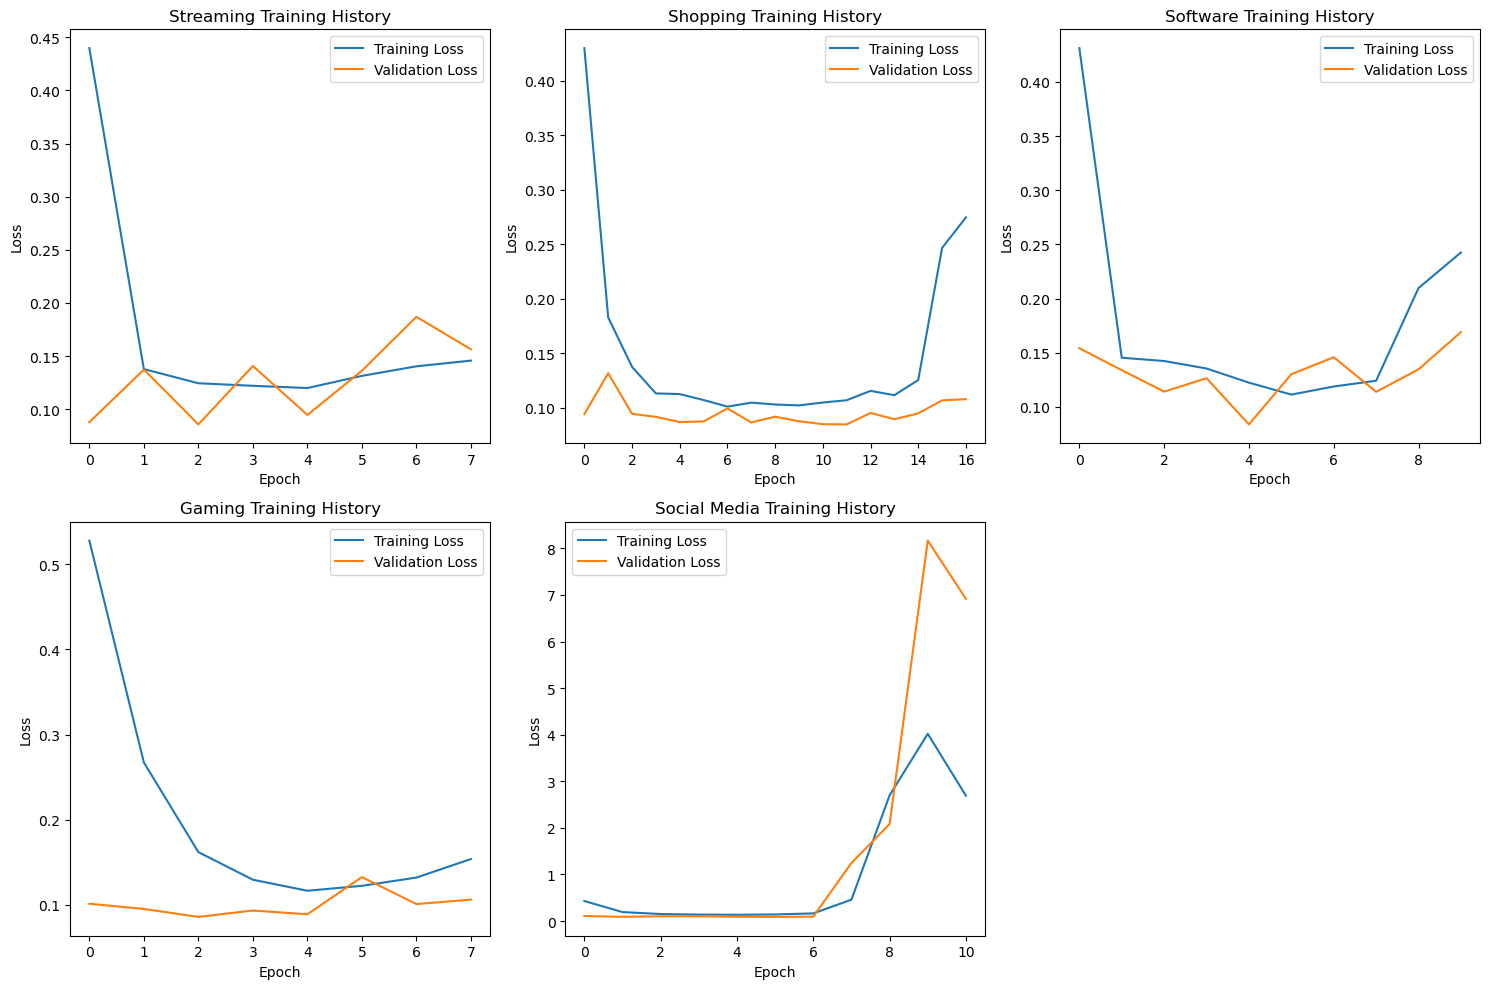

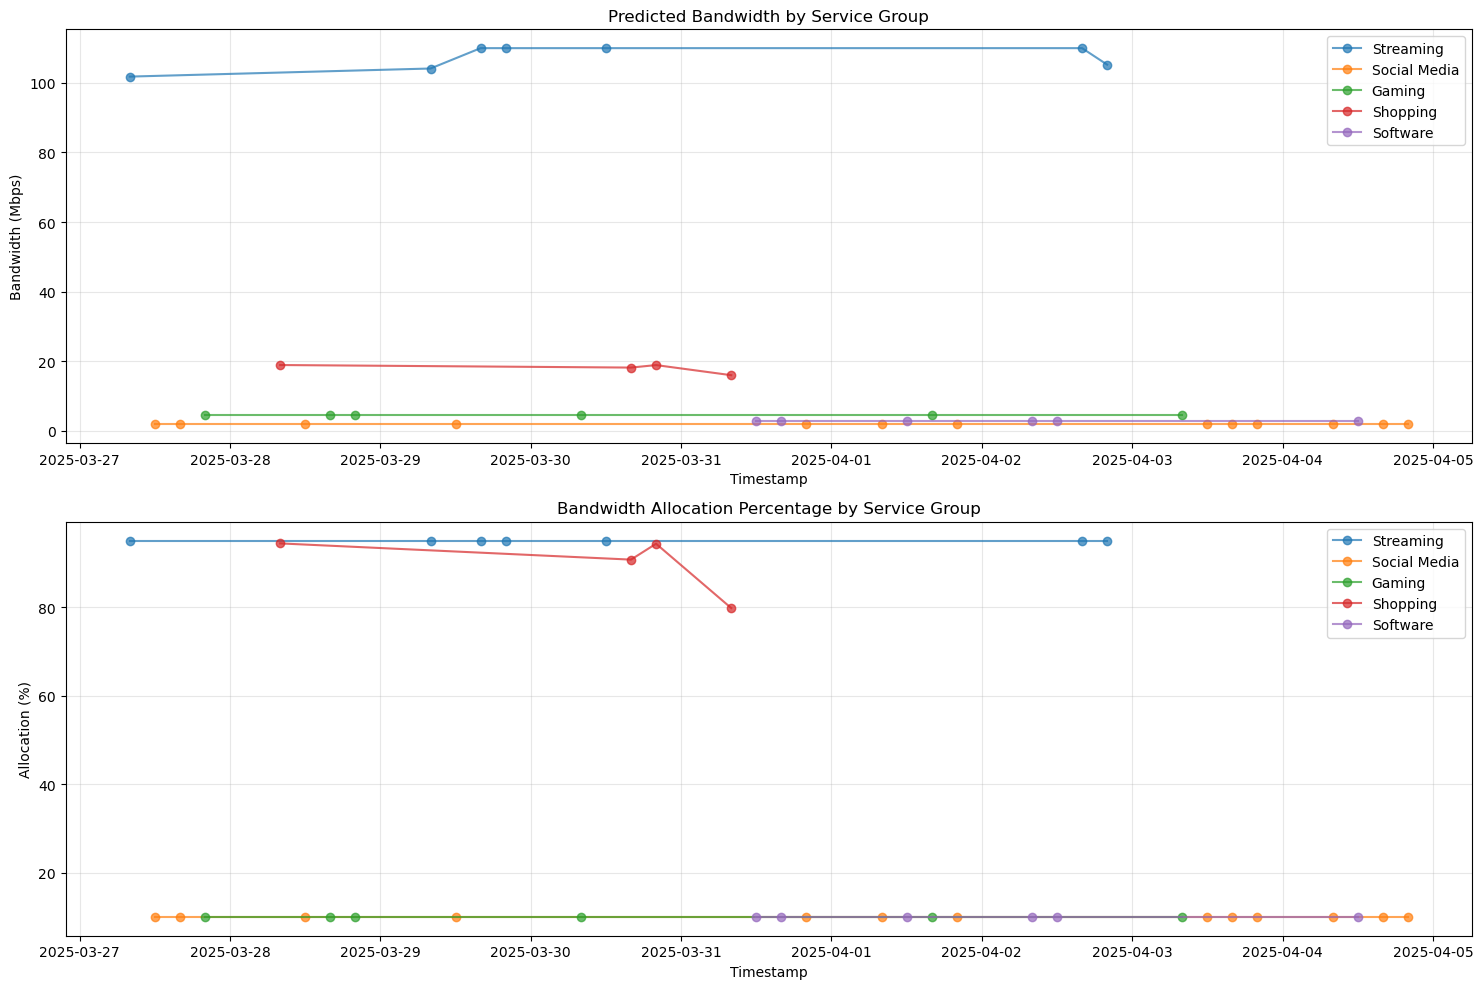

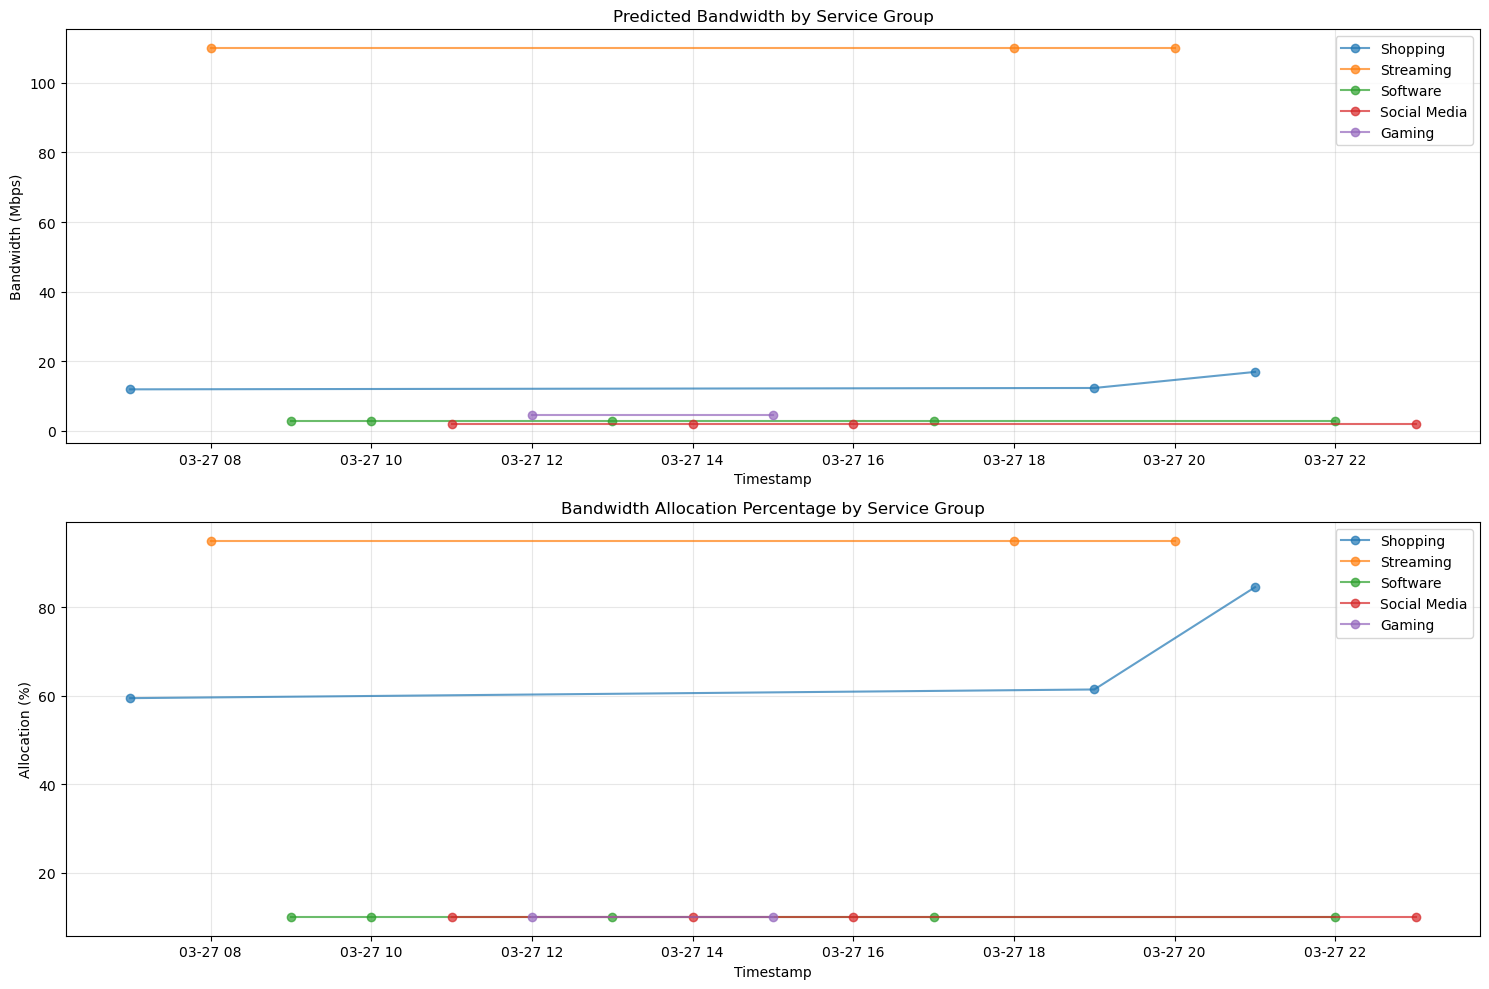

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import json
import os
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

class BandwidthAllocationPredictor:
    def __init__(self, dataset_path):
        """
        Initialize predictor with dataset path
        """
        # Load the dataset
        self.df = pd.read_csv(dataset_path)
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        
        # Print column names to diagnose naming issues
        print("Available columns in dataset:", list(self.df.columns))
        
        # Create mapping dictionaries for service groups and names
        self.service_groups = self.df['service_group'].unique()
        print(f"Service groups in dataset: {list(self.service_groups)}")
        
        self.group_ids = {}
        self.service_ids = {}
        
        for _, row in self.df[['service_group', 'group_id', 'service_name', 'service_id']].drop_duplicates().iterrows():
            self.group_ids[row['service_group']] = row['group_id']
            if row['service_name'] not in self.service_ids:
                self.service_ids[row['service_name']] = row['service_id']
        
        # Analysis of bandwidth distribution
        self.analyze_bandwidth_distribution()
        
        # Prepare features for prediction
        self.prepare_features()
    
    def analyze_bandwidth_distribution(self):
        """
        Analyze the distribution of bandwidth values to determine appropriate scaling
        """
        bandwidth_col = 'bandwidth_speed'
        
        # Calculate statistics
        bandwidth_min = self.df[bandwidth_col].min()
        bandwidth_max = self.df[bandwidth_col].max()
        bandwidth_mean = self.df[bandwidth_col].mean()
        bandwidth_median = self.df[bandwidth_col].median()
        bandwidth_std = self.df[bandwidth_col].std()
        
        print("\nBandwidth Distribution Analysis:")
        print(f"Min: {bandwidth_min:.2f}, Max: {bandwidth_max:.2f}")
        print(f"Mean: {bandwidth_mean:.2f}, Median: {bandwidth_median:.2f}")
        print(f"Standard Deviation: {bandwidth_std:.2f}")
        
        # Store for scaling during prediction
        self.bandwidth_stats = {
            'min': bandwidth_min,
            'max': bandwidth_max,
            'mean': bandwidth_mean,
            'median': bandwidth_median,
            'std': bandwidth_std
        }
        
        # Analyze by service group
        print("\nBandwidth by Service Group:")
        self.service_group_stats = {}
        for group in self.service_groups:
            group_data = self.df[self.df['service_group'] == group]
            if len(group_data) > 0:
                group_min = group_data[bandwidth_col].min()
                group_max = group_data[bandwidth_col].max()
                group_mean = group_data[bandwidth_col].mean()
                group_median = group_data[bandwidth_col].median()
                group_std = group_data[bandwidth_col].std()
                
                self.service_group_stats[group] = {
                    'min': group_min,
                    'max': group_max,
                    'mean': group_mean,
                    'median': group_median,
                    'std': group_std,
                    'count': len(group_data)
                }
                
                print(f"{group}: Min={group_min:.2f}, Max={group_max:.2f}, Mean={group_mean:.2f}, Median={group_median:.2f}, Count={len(group_data)}")
    
    def prepare_features(self):
        """
        Prepare features for the model including network metrics
        """
        self.bandwidth_col = 'bandwidth_speed'
        
        # Add time-based features if they don't exist
        if 'hour' not in self.df.columns:
            self.df['hour'] = self.df['timestamp'].dt.hour
            print("Added 'hour' column from timestamp")
        
        if 'day_of_week' not in self.df.columns:
            self.df['day_of_week'] = self.df['timestamp'].dt.dayofweek
            print("Added 'day_of_week' column from timestamp")
        
        if 'is_weekend' not in self.df.columns:
            self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)
            print("Added 'is_weekend' column from day_of_week")
        
        # Add one-hot encoding for hour
        for h in range(24):
            col_name = f'hour_{h}'
            self.df[col_name] = (self.df['hour'] == h).astype(int)
        
        # Add one-hot encoding for day of week
        for d in range(7):
            col_name = f'day_{d}'
            self.df[col_name] = (self.df['day_of_week'] == d).astype(int)
        
        # Handle device_group
        if 'device_group' in self.df.columns and 'device_group_encoded' not in self.df.columns:
            self.df['device_group_encoded'] = self.df['device_group'].map({'personal_device': 0, 'work_device': 1})
            print("Added 'device_group_encoded' from device_group")
        
        # Select relevant features
        self.time_features = ['hour', 'day_of_week', 'is_weekend']
        self.hour_features = [f'hour_{h}' for h in range(24)]
        self.day_features = [f'day_{d}' for d in range(7)]
        
        # Basic features including network metrics if available
        self.basic_features = ['usage_percentage']
        if 'device_group_encoded' in self.df.columns:
            self.basic_features.append('device_group_encoded')
        
        # Add network metrics if available
        self.network_features = []
        for feature in ['signal_strength', 'packet_loss', 'latency', 'jitter', 'usage_minutes']:
            if feature in self.df.columns:
                self.network_features.append(feature)
            
        print(f"Using network features: {self.network_features}")
        
        # All features combined
        self.features = self.basic_features + self.network_features + self.time_features + self.hour_features + self.day_features
        
        # Initialize scalers for each service group
        self.scalers = {}
        self.service_group_data = {}
        
        # Group and process data for each service group separately
        for service_group in self.service_groups:
            print(f"Processing data for {service_group}...")
            group_data = self.df[self.df['service_group'] == service_group].copy()
            
            # Ensure all required features exist
            all_features_available = True
            for feature in self.features:
                if feature not in group_data.columns:
                    if feature in self.hour_features or feature in self.day_features:
                        # It's fine if we created these
                        continue
                    print(f"Warning: Feature {feature} not found for {service_group}, using zeros")
                    group_data[feature] = 0
                    all_features_available = False
            
            # Store service group data
            self.service_group_data[service_group] = {
                'data': group_data,
                'features_available': all_features_available,
                'service_ids': group_data['service_id'].unique()
            }
            
            # Initialize and fit scaler for this group
            feature_scaler = MinMaxScaler()
            feature_scaler.fit(group_data[self.features])
            
            # Initialize and fit target scaler
            target_scaler = MinMaxScaler()
            target_scaler.fit(group_data[[self.bandwidth_col]])
            
            self.scalers[service_group] = {
                'features': feature_scaler,
                'target': target_scaler
            }
    
    def create_transformer_model(self, input_dim):
        """
        Create a transformer-based model compatible with TFLite
        """
        inputs = Input(shape=(input_dim,))
        
        # Reshape inputs for attention mechanism
        x = tf.expand_dims(inputs, axis=1)
        
        # First transformer block
        attention_output = MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.1
        )(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attention_output)
        
        # Flatten attention output
        x = tf.keras.layers.Flatten()(x)
        
        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.1)(x)
        outputs = Dense(1, activation='linear')(x)
        
        # Create model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse'
        )
        
        return model
    
    def prepare_training_data(self, service_group):
        """
        Prepare training data for the model with proper scaling
        """
        data = self.service_group_data[service_group]['data']
        feature_scaler = self.scalers[service_group]['features']
        target_scaler = self.scalers[service_group]['target']
        
        # Scale the features
        X = feature_scaler.transform(data[self.features])
        
        # Scale the target (bandwidth)
        y = target_scaler.transform(data[[self.bandwidth_col]]).ravel()
        
        return X, y
    
    def train_models(self, epochs=30, batch_size=32, validation_split=0.2):
        """
        Train transformer models for each service group
        """
        self.models = {}
        self.training_history = {}
        
        for service_group in self.service_groups:
            print(f"Training model for {service_group}...")
            
            # Skip if features are not available
            if not self.service_group_data[service_group]['features_available']:
                print(f"  Skipping {service_group} due to missing features")
                continue
            
            # Skip if not enough data
            if len(self.service_group_data[service_group]['data']) < 100:
                print(f"  Not enough data for {service_group}, skipping")
                continue
            
            # Try to prepare data
            try:
                X, y = self.prepare_training_data(service_group)
                
                if len(X) == 0:
                    print(f"  No valid data for {service_group}, skipping")
                    continue
                
                # Create model
                model = self.create_transformer_model(X.shape[1])
                
                # Add early stopping
                early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                )
                
                # Train model
                history = model.fit(
                    X, y, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=validation_split,
                    callbacks=[early_stopping],
                    verbose=1
                )
                
                # Convert to TFLite model using only built-in ops
                converter = tf.lite.TFLiteConverter.from_keras_model(model)
                converter.target_spec.supported_ops = [
                    tf.lite.OpsSet.TFLITE_BUILTINS
                ]
                
                # Optimize for size and latency
                converter.optimizations = [tf.lite.Optimize.DEFAULT]
                
                # Convert model
                try:
                    tflite_model = converter.convert()
                    print(f"  Successfully converted model to TFLite format")
                    
                    # Save the model
                    model_dir = "tflite_models"
                    os.makedirs(model_dir, exist_ok=True)
                    model_path = os.path.join(model_dir, f"{service_group.lower().replace(' ', '_')}_model.tflite")
                    
                    with open(model_path, "wb") as f:
                        f.write(tflite_model)
                    
                    print(f"  Model saved as {model_path}")
                    
                    # Store model and history
                    self.models[service_group] = {
                        'keras_model': model,
                        'tflite_model': tflite_model
                    }
                    
                    self.training_history[service_group] = history.history
                    
                    # Verify prediction on training data
                    self.verify_model_predictions(service_group, X[:5], y[:5])
                    
                except Exception as e:
                    print(f"  Error converting model to TFLite: {str(e)}")
                    print("  Using fallback dense model")
                    
                    # Create a fallback model with only dense layers
                    fallback_model = Sequential([
                        Dense(64, activation='relu', input_shape=(X.shape[1],)),
                        Dropout(0.1),
                        Dense(32, activation='relu'),
                        Dropout(0.1),
                        Dense(1, activation='linear')
                    ])
                    
                    fallback_model.compile(optimizer='adam', loss='mse')
                    
                    fallback_history = fallback_model.fit(
                        X, y, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split,
                        callbacks=[early_stopping],
                        verbose=1
                    )
                    
                    # Convert fallback model to TFLite
                    converter = tf.lite.TFLiteConverter.from_keras_model(fallback_model)
                    converter.target_spec.supported_ops = [
                        tf.lite.OpsSet.TFLITE_BUILTINS
                    ]
                    
                    tflite_model = converter.convert()
                    
                    model_path = os.path.join(model_dir, f"{service_group.lower().replace(' ', '_')}_fallback_model.tflite")
                    
                    with open(model_path, "wb") as f:
                        f.write(tflite_model)
                    
                    print(f"  Fallback model saved as {model_path}")
                    
                    # Store fallback model
                    self.models[service_group] = {
                        'keras_model': fallback_model,
                        'tflite_model': tflite_model
                    }
                    
                    self.training_history[service_group] = fallback_history.history
            
            except Exception as e:
                print(f"  Error training model for {service_group}: {str(e)}")
                continue
        
        # Plot training history
        self.plot_training_history()
        
        # Export metadata for edge deployment
        self.export_metadata()
    
    def verify_model_predictions(self, service_group, X_sample, y_sample):
        """
        Verify model predictions on sample data
        """
        model = self.models[service_group]['keras_model']
        target_scaler = self.scalers[service_group]['target']
        
        # Get predictions
        y_pred = model.predict(X_sample)
        
        # Inverse transform
        y_pred_orig = target_scaler.inverse_transform(y_pred)
        y_sample_orig = target_scaler.inverse_transform(y_sample.reshape(-1, 1))
        
        print(f"\nVerification for {service_group}:")
        print("Sample predictions (scaled):", y_pred.flatten())
        print("Sample actual values (scaled):", y_sample)
        print("Sample predictions (original scale):", y_pred_orig.flatten())
        print("Sample actual values (original scale):", y_sample_orig.flatten())
    
    def plot_training_history(self):
        """
        Plot training history for all models
        """
        if not self.training_history:
            print("No training history available to plot")
            return
        
        plt.figure(figsize=(15, 10))
        i = 1
        
        for service_group, history in self.training_history.items():
            if 'loss' in history and 'val_loss' in history:
                plt.subplot(2, 3, i)
                plt.plot(history['loss'], label='Training Loss')
                plt.plot(history['val_loss'], label='Validation Loss')
                plt.title(f'{service_group} Training History')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                i += 1
                if i > 6:
                    break
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        print("Training history plot saved as 'training_history.png'")
    
    def export_metadata(self, output_dir="metadata"):
        """
        Export metadata for edge deployment
        """
        os.makedirs(output_dir, exist_ok=True)
        
        # Custom JSON encoder to handle NumPy types
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, (np.integer, np.int64)):
                    return int(obj)
                elif isinstance(obj, (np.floating, np.float64)):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NumpyEncoder, self).default(obj)
        
        # 1. Export service mappings
        service_mappings = {}
        for service_group in self.service_groups:
            service_mappings[service_group] = {
                "group_id": self.group_ids.get(service_group, 1001),
                "services": {}
            }
            
            # Find services for this group
            for service_name, service_id in self.service_ids.items():
                service_data = self.df[(self.df['service_group'] == service_group) & 
                                    (self.df['service_name'] == service_name)]
                if len(service_data) > 0:
                    service_mappings[service_group]["services"][service_name] = service_id
        
        with open(os.path.join(output_dir, "service_mappings.json"), "w") as f:
            json.dump(service_mappings, f, indent=2, cls=NumpyEncoder)
        
        # 2. Export service group stats
        with open(os.path.join(output_dir, "service_group_stats.json"), "w") as f:
            json.dump(self.service_group_stats, f, indent=2, cls=NumpyEncoder)
        
        # 3. Export feature list
        with open(os.path.join(output_dir, "feature_list.json"), "w") as f:
            feature_info = {
                "basic_features": self.basic_features,
                "network_features": self.network_features,
                "time_features": self.time_features,
                "hour_features": self.hour_features,
                "day_features": self.day_features,
                "all_features": self.features
            }
            json.dump(feature_info, f, indent=2)
        
        # 4. Export scaler parameters
        scaler_params = {}
        for service_group, scalers in self.scalers.items():
            feature_scaler = scalers['features']
            target_scaler = scalers['target']
            
            scaler_params[service_group] = {
                "features": {
                    "min": feature_scaler.min_.tolist(),
                    "scale": feature_scaler.scale_.tolist()
                },
                "target": {
                    "min": target_scaler.min_.tolist(),
                    "scale": target_scaler.scale_.tolist()
                }
            }
        
        with open(os.path.join(output_dir, "scalers.json"), "w") as f:
            json.dump(scaler_params, f, indent=2)
        
        print(f"Exported metadata files to {output_dir}")

    def predict_custom_date_range(self, start_date, end_date, interval='4H'):
        """
        Generate predictions for a custom date range
        
        Parameters:
        -----------
        start_date : str or datetime
            Start date for predictions
        end_date : str or datetime
            End date for predictions
        interval : str, optional
            Time interval between predictions (e.g. '4H', '30min')
            
        Returns:
        --------
        dict
            Prediction results in JSON format
        """
        # Convert string dates to datetime if needed
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        if isinstance(end_date, str):
            end_date = pd.to_datetime(end_date)
            
        # Format the date range for output filename
        start_str = start_date.strftime('%Y-%m-%d')
        end_str = end_date.strftime('%Y-%m-%d')
        output_file = f'predictions_{start_str}_to_{end_str}.json'
        
        # Generate and save predictions
        result = self.save_prediction_to_json(
            start_date=start_date,
            end_date=end_date,
            interval=interval,
            output_file=output_file
        )
        
        print(f"Generated predictions from {start_str} to {end_str} at {interval} intervals")
        return result
        
    def save_prediction_to_json(self, start_date, end_date, interval='2H', output_file='predicted_bandwidth_output.json'):
        """
        Generate predictions and save to JSON
        """
        # Custom JSON encoder to handle NumPy types
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, (np.integer, np.int64)):
                    return int(obj)
                elif isinstance(obj, (np.floating, np.float64)):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NumpyEncoder, self).default(obj)
        
        # Check if we have any models
        if not self.models:
            print("No trained models available. Cannot generate predictions.")
            # Create a minimal placeholder prediction with one entry
            prediction_results = {
                datetime.now().strftime('%Y-%m-%d %H:%M:%S'): {
                    "service_group": list(self.service_groups)[0],
                    "group_id": int(self.group_ids.get(list(self.service_groups)[0], 1001)),
                    "service_id": 101,
                    "bandwidth_allocation": "50.00%"
                }
            }
            output_data = {"responseData": prediction_results}
            
            with open(output_file, 'w') as f:
                json.dump(output_data, f, indent=2, cls=NumpyEncoder)
            return output_data
        
        # Convert dates to datetime
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        # Generate timestamps
        all_timestamps = pd.date_range(start=start_date, end=end_date, freq=interval)
        
        # Filter timestamps to only include 7 AM to 12 AM (midnight)
        timestamps = [ts for ts in all_timestamps if 7 <= ts.hour < 24]
        
        # Prepare prediction results
        prediction_results = {}
        all_predictions = []
        
        for timestamp in timestamps:
            # Determine service group based on hour
            hour = timestamp.hour
            day_of_week = timestamp.weekday()
            is_weekend = day_of_week >= 5
            
            # Define service group probabilities based on time
            if 9 <= hour <= 17 and not is_weekend:
                # Work hours on weekdays - higher probability for Software
                group_probs = {
                    "Software": 0.5,
                    "Streaming": 0.1,
                    "Social Media": 0.2,
                    "Shopping": 0.1,
                    "Gaming": 0.1
                }
            elif 18 <= hour <= 23:
                # Evening hours - higher probability for Streaming and Gaming
                group_probs = {
                    "Software": 0.1,
                    "Streaming": 0.4,
                    "Social Media": 0.2,
                    "Shopping": 0.1,
                    "Gaming": 0.2
                }
            elif 7 <= hour <= 8:
                # Morning hours - higher probability for Social Media
                group_probs = {
                    "Software": 0.2,
                    "Streaming": 0.2,
                    "Social Media": 0.4,
                    "Shopping": 0.1,
                    "Gaming": 0.1
                }
            elif is_weekend:
                # Weekend - varied usage
                group_probs = {
                    "Software": 0.1,
                    "Streaming": 0.3,
                    "Social Media": 0.2,
                    "Shopping": 0.2,
                    "Gaming": 0.2
                }
            else:
                # Default distribution
                group_probs = {
                    "Software": 0.2,
                    "Streaming": 0.2,
                    "Social Media": 0.2,
                    "Shopping": 0.2,
                    "Gaming": 0.2
                }
            
            # Filter to only include groups we have models for
            available_groups = set(self.models.keys())
            group_probs = {k: v for k, v in group_probs.items() if k in available_groups}
            
            if group_probs:
                # Normalize probabilities
                total = sum(group_probs.values())
                group_probs = {k: v/total for k, v in group_probs.items()}
                
                # Select a service group based on probabilities
                groups = list(group_probs.keys())
                probs = list(group_probs.values())
                service_group = random.choices(groups, weights=probs, k=1)[0]
            else:
                # Fallback to random selection if no probabilities are valid
                service_group = random.choice(list(self.models.keys()))
            
            # Get service IDs for this group
            service_ids = self.service_group_data[service_group]['service_ids']
            if len(service_ids) == 0:
                # If no service IDs available, use a placeholder
                service_id = 101
            else:
                service_id = random.choice(service_ids)
                # Convert NumPy types to Python native types
                if isinstance(service_id, np.integer):
                    service_id = int(service_id)
            
            # Generate features
            input_features = self.generate_realistic_features(timestamp, service_group)
            
            # Scale the features
            scaled_features = self.scalers[service_group]['features'].transform(input_features)
            
            # Use TFLite interpreter for prediction
            interpreter = tf.lite.Interpreter(model_content=self.models[service_group]['tflite_model'])
            interpreter.allocate_tensors()
            
            # Get input and output details
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            
            # Set input tensor
            interpreter.set_tensor(input_details[0]['index'], scaled_features.astype(np.float32))
            
            # Run inference
            interpreter.invoke()
            
            # Get output
            scaled_prediction = interpreter.get_tensor(output_details[0]['index'])
            
            # Inverse transform to get the original bandwidth scale
            bandwidth_prediction = self.scalers[service_group]['target'].inverse_transform(
                scaled_prediction.reshape(-1, 1)
            )[0][0]
            
            # Apply constraints based on service group stats
            if service_group in self.service_group_stats:
                stats = self.service_group_stats[service_group]
                max_val = stats['max']
                constrained_bandwidth = max(min(bandwidth_prediction, max_val * 1.1), stats['min'] * 0.9)
            else:
                # Fallback to global constraints
                constrained_bandwidth = max(min(bandwidth_prediction, self.bandwidth_stats['max'] * 1.1), 
                                           self.bandwidth_stats['min'] * 0.9)
            
            # Calculate allocation percentage based on maximum possible bandwidth
            if service_group in self.service_group_stats:
                max_bandwidth = self.service_group_stats[service_group]['max']
                allocation_percentage = (constrained_bandwidth / max_bandwidth) * 100
            else:
                # Fallback to global maximum
                allocation_percentage = (constrained_bandwidth / self.bandwidth_stats['max']) * 100
            
            # Ensure percentage is within reasonable bounds
            allocation_percentage = max(min(allocation_percentage, 95), 10)
            
            # Format for output
            formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
                
            prediction_entry = {
                "service_group": service_group,
                "group_id": int(self.group_ids.get(service_group, 1001)),
                "service_id": int(service_id),
                "bandwidth_allocation": f"{allocation_percentage:.2f}%",
                "predicted_bandwidth_mbps": f"{constrained_bandwidth:.2f}"
            }
            
            prediction_results[formatted_timestamp] = prediction_entry
            
            # Add to list for analysis
            all_predictions.append({
                "timestamp": formatted_timestamp,
                "service_group": service_group,
                "predicted_bandwidth": float(constrained_bandwidth),
                "allocation_percentage": float(allocation_percentage)
            })
        
        # Create output data structure
        output_data = {
            "responseData": prediction_results
        }
        
        # Save to JSON file
        with open(output_file, 'w') as f:
            json.dump(output_data, f, indent=2, cls=NumpyEncoder)
        
        print(f"Predictions saved to {output_file}")
        
        # Generate summary plot
        self.plot_prediction_summary(all_predictions)
        
        return output_data
        
    def generate_realistic_features(self, timestamp, service_group, usage_percentage=None, device_group=None):
        """
        Generate realistic feature values for a timestamp and service group
        """
        hour = timestamp.hour
        day_of_week = timestamp.weekday()
        is_weekend = 1 if day_of_week >= 5 else 0
        
        # Hour one-hot encoding
        hour_features = [1 if h == hour else 0 for h in range(24)]
        
        # Day one-hot encoding
        day_features = [1 if d == day_of_week else 0 for d in range(7)]
        
        # Generate usage percentage based on time patterns if not provided
        if usage_percentage is None:
            # Define usage patterns by service group and time of day
            usage_patterns = {
                "Streaming": {
                    "morning": (5, 9, 30, 50),      # 5-9 AM: 30-50%
                    "workday": (9, 17, 40, 60),     # 9 AM-5 PM: 40-60%
                    "evening": (17, 23, 70, 90),    # 5-11 PM: 70-90%
                    "night": (23, 5, 50, 70),       # 11 PM-5 AM: 50-70%
                    "weekend_boost": 10             # +10% on weekends
                },
                "Gaming": {
                    "morning": (5, 9, 20, 40),      # 5-9 AM: 20-40%
                    "workday": (9, 17, 30, 50),     # 9 AM-5 PM: 30-50%
                    "evening": (17, 23, 75, 95),    # 5-11 PM: 75-95%
                    "night": (23, 5, 60, 80),       # 11 PM-5 AM: 60-80%
                    "weekend_boost": 15             # +15% on weekends
                },
                "Social Media": {
                    "morning": (5, 9, 50, 70),      # 5-9 AM: 50-70%
                    "workday": (9, 17, 60, 80),     # 9 AM-5 PM: 60-80%
                    "evening": (17, 23, 70, 90),    # 5-11 PM: 70-90%
                    "night": (23, 5, 40, 60),       # 11 PM-5 AM: 40-60%
                    "weekend_boost": 5              # +5% on weekends
                },
                "Shopping": {
                    "morning": (5, 9, 30, 50),      # 5-9 AM: 30-50%
                    "workday": (9, 17, 50, 70),     # 9 AM-5 PM: 50-70%
                    "evening": (17, 23, 60, 80),    # 5-11 PM: 60-80%
                    "night": (23, 5, 20, 40),       # 11 PM-5 AM: 20-40%
                    "weekend_boost": 10             # +10% on weekends
                },
                "Software": {
                    "morning": (5, 9, 60, 80),      # 5-9 AM: 60-80%
                    "workday": (9, 17, 80, 95),     # 9 AM-5 PM: 80-95%
                    "evening": (17, 23, 40, 60),    # 5-11 PM: 40-60%
                    "night": (23, 5, 20, 40),       # 11 PM-5 AM: 20-40%
                    "weekend_boost": -20            # -20% on weekends
                }
            }
            
            # Use a default pattern if the service group is not defined
            pattern = usage_patterns.get(service_group, {
                "morning": (5, 9, 40, 60),
                "workday": (9, 17, 50, 70),
                "evening": (17, 23, 60, 80),
                "night": (23, 5, 30, 50),
                "weekend_boost": 5
            })
            
            # Determine which time period we're in
            if pattern["morning"][0] <= hour < pattern["morning"][1]:
                min_usage, max_usage = pattern["morning"][2], pattern["morning"][3]
            elif pattern["workday"][0] <= hour < pattern["workday"][1]:
                min_usage, max_usage = pattern["workday"][2], pattern["workday"][3]
            elif pattern["evening"][0] <= hour < pattern["evening"][1]:
                min_usage, max_usage = pattern["evening"][2], pattern["evening"][3]
            else:  # night
                min_usage, max_usage = pattern["night"][2], pattern["night"][3]
            
            # Add weekend boost if applicable
            if is_weekend:
                min_usage += pattern["weekend_boost"]
                max_usage += pattern["weekend_boost"]
                
            # Ensure within 0-100 range
            min_usage = max(0, min(100, min_usage))
            max_usage = max(0, min(100, max_usage))
            
            # Generate random usage percentage within the determined range
            usage_percentage = random.uniform(min_usage, max_usage)
        
        # Determine device group if not provided
        if device_group is None:
            # Default logic: work devices more likely during work hours
            if service_group == "Software" and 8 <= hour <= 18 and day_of_week < 5:
                device_group_encoded = 1  # work device
            else:
                device_group_encoded = 0  # personal device
        else:
            # Use provided device group
            device_group_encoded = 1 if device_group == "work_device" else 0
        
        # Generate network metrics based on service group and time
        # These values are based on the same patterns used in data generation
        if service_group == "Streaming":
            signal_strength = random.uniform(-70, -30)
            packet_loss = random.uniform(0, 0.2)
            latency = random.uniform(10, 50)
            jitter = random.uniform(1, 5)
        elif service_group == "Gaming":
            signal_strength = random.uniform(-65, -25)
            packet_loss = random.uniform(0, 0.1)
            latency = random.uniform(5, 30)
            jitter = random.uniform(0.5, 3)
        elif service_group == "Social Media":
            signal_strength = random.uniform(-75, -40)
            packet_loss = random.uniform(0, 0.3)
            latency = random.uniform(20, 80)
            jitter = random.uniform(2, 8)
        elif service_group == "Shopping":
            signal_strength = random.uniform(-80, -45)
            packet_loss = random.uniform(0, 0.4)
            latency = random.uniform(30, 100)
            jitter = random.uniform(3, 10)
        else:  # Software
            signal_strength = random.uniform(-70, -35)
            packet_loss = random.uniform(0, 0.2)
            latency = random.uniform(15, 70)
            jitter = random.uniform(1, 7)
            
        # Calculate usage minutes based on usage percentage
        usage_minutes = usage_percentage * 0.3  # Similar to data generation
            
        # Combine all features
        # Basic features
        feature_values = [usage_percentage]
        if 'device_group_encoded' in self.basic_features:
            feature_values.append(device_group_encoded)
        
        # Network features
        network_values = []
        if 'signal_strength' in self.network_features:
            network_values.append(signal_strength)
        if 'packet_loss' in self.network_features:
            network_values.append(packet_loss)
        if 'latency' in self.network_features:
            network_values.append(latency)
        if 'jitter' in self.network_features:
            network_values.append(jitter)
        if 'usage_minutes' in self.network_features:
            network_values.append(usage_minutes)
        
        # Time features
        time_values = [hour, day_of_week, is_weekend]
        
        # Combine all features into a single vector
        all_features = feature_values + network_values + time_values + hour_features + day_features
        
        return np.array(all_features).reshape(1, -1)
        
    def plot_prediction_summary(self, all_predictions):
        """
        Generate a summary plot of the predictions
        """
        if not all_predictions:
            print("No predictions to plot")
            return
        
        # Convert to DataFrame for easier analysis
        pred_df = pd.DataFrame(all_predictions)
        pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'])
        
        # Plot by service group
        plt.figure(figsize=(15, 10))
        
        # Top plot: Bandwidth predictions over time by service group
        plt.subplot(2, 1, 1)
        for group in pred_df['service_group'].unique():
            group_data = pred_df[pred_df['service_group'] == group]
            plt.plot(group_data['timestamp'], group_data['predicted_bandwidth'], 
                     label=group, marker='o', linestyle='-', alpha=0.7)
        
        plt.title('Predicted Bandwidth by Service Group')
        plt.xlabel('Timestamp')
        plt.ylabel('Bandwidth (Mbps)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Bottom plot: Allocation percentages over time by service group
        plt.subplot(2, 1, 2)
        for group in pred_df['service_group'].unique():
            group_data = pred_df[pred_df['service_group'] == group]
            plt.plot(group_data['timestamp'], group_data['allocation_percentage'], 
                     label=group, marker='o', linestyle='-', alpha=0.7)
        
        plt.title('Bandwidth Allocation Percentage by Service Group')
        plt.xlabel('Timestamp')
        plt.ylabel('Allocation (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('prediction_summary.png')
        print("Prediction summary plot saved as 'prediction_summary.png'")

    def generate_daily_recommendations(self, date=None):
        """
        Generate daily bandwidth allocation recommendations
        
        Parameters:
        -----------
        date : str or datetime, optional
            Date for recommendations (defaults to today)
            
        Returns:
        --------
        dict
            Recommendations data
        """
        if date is None:
            date = datetime.now().date()
        else:
            date = pd.to_datetime(date).date()
        
        # Generate hourly predictions for the given date
        start_date = datetime.combine(date, datetime.min.time())
        end_date = datetime.combine(date, datetime.max.time())
        
        # Generate predictions
        predictions = self.save_prediction_to_json(
            start_date, 
            end_date, 
            interval='1H', 
            output_file=f'daily_recommendations_{date.strftime("%Y%m%d")}.json'
        )
        
        # Analyze predictions for recommendations
        recommendations = {
            "date": date.strftime('%Y-%m-%d'),
            "peak_usage_hours": [],
            "service_recommendations": {}
        }
        
        # Extract prediction data
        pred_data = predictions.get("responseData", {})
        if not pred_data:
            return recommendations
        
        # Convert to DataFrame for analysis
        pred_records = []
        for timestamp, data in pred_data.items():
            rec = {
                "timestamp": pd.to_datetime(timestamp),
                "service_group": data["service_group"],
                "allocation_percentage": float(data["bandwidth_allocation"].replace("%", "")),
                "predicted_bandwidth_mbps": float(data.get("predicted_bandwidth_mbps", 0))
            }
            pred_records.append(rec)
        
        pred_df = pd.DataFrame(pred_records)
        
        # Find peak usage hours (top 3)
        hourly_avg = pred_df.groupby(pred_df['timestamp'].dt.hour)['allocation_percentage'].mean()
        peak_hours = hourly_avg.nlargest(3).index.tolist()
        recommendations["peak_usage_hours"] = [f"{hour}:00" for hour in peak_hours]
        
        # Recommendations by service group
        for group in pred_df['service_group'].unique():
            group_data = pred_df[pred_df['service_group'] == group]
            avg_allocation = group_data['allocation_percentage'].mean()
            max_allocation = group_data['allocation_percentage'].max()
            peak_hour = group_data.loc[group_data['allocation_percentage'].idxmax(), 'timestamp'].hour
            
            # Generate specific recommendations
            if avg_allocation > 75:
                recommendation = "Critical: Increase bandwidth allocation significantly"
            elif avg_allocation > 60:
                recommendation = "High: Consider increasing bandwidth allocation"
            elif avg_allocation > 40:
                recommendation = "Moderate: Current allocation is sufficient"
            else:
                recommendation = "Low: Bandwidth allocation can be reduced"
            
            recommendations["service_recommendations"][group] = {
                "average_allocation": f"{avg_allocation:.2f}%",
                "peak_allocation": f"{max_allocation:.2f}%",
                "peak_hour": f"{peak_hour}:00",
                "recommendation": recommendation
            }
        
        # Custom JSON encoder to handle NumPy types
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, (np.integer, np.int64)):
                    return int(obj)
                elif isinstance(obj, (np.floating, np.float64)):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NumpyEncoder, self).default(obj)
        
        # Save recommendations to file
        recommendations_file = f'recommendations_{date.strftime("%Y%m%d")}.json'
        with open(recommendations_file, 'w') as f:
            json.dump(recommendations, f, indent=2, cls=NumpyEncoder)
        
        print(f"Daily recommendations saved to {recommendations_file}")
        return recommendations

# Main function to run when the script is executed
if __name__ == "__main__":
    # Initialize and train the model
    predictor = BandwidthAllocationPredictor(dataset_path='network_dataset.csv')
    predictor.train_models(epochs=20)
    
    # Generate predictions for a custom date range
    predictor.predict_custom_date_range(
        start_date='2025-03-27',
        end_date='2025-04-05',
        interval='4H'
    )
    
    # Generate daily recommendations for March 27, 2025
    predictor.generate_daily_recommendations(date='2025-03-27')